In [2]:
import pandas as pd
import numpy as np
import chess

def board_to_array(fen):
    board = chess.Board(fen)
    piece_dict = {'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
                  'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6}
    array = np.zeros((8, 8), dtype=np.int8)
    for i in range(64):
        piece = board.piece_at(i)
        if piece:
            array[i // 8][i % 8] = piece_dict[piece.symbol()]
    return array

def move_to_index(move):
    # Extract just the 'from' and 'to' squares, ignoring promotion
    from_square = move[:2]
    to_square = move[2:4]
    return chess.SQUARE_NAMES.index(from_square) * 64 + chess.SQUARE_NAMES.index(to_square)

# Load the data
train_df = pd.read_csv('C:/Users/sharm/OneDrive/Desktop/Train_AI_Chess/train-an-ai-to-play-chess/train.csv')
test_df = pd.read_csv('C:/Users/sharm/OneDrive/Desktop/Train_AI_Chess/train-an-ai-to-play-chess/test.csv')


# Preprocess training data
X_train = np.array([board_to_array(board) for board in train_df['board']])
y_train_score = np.array(train_df['black_score'])
y_train_move = np.array([move_to_index(move) for move in train_df['best_move']])

# Preprocess test data
X_test = np.array([board_to_array(board) for board in test_df['board']])

# Reshape input data for the neural network
X_train = X_train.reshape((-1, 8, 8, 1))
X_test = X_test.reshape((-1, 8, 8, 1))

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Concatenate

def create_model():
    board_input = Input(shape=(8, 8, 1))
    x = Conv2D(64, (3, 3), activation='relu')(board_input)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    
    # Output layer for move prediction
    move_output = Dense(64 * 64, activation='softmax', name='move')(x)
    
    # Output layer for score prediction
    score_output = Dense(1, name='score')(x)
    
    model = Model(inputs=board_input, outputs=[move_output, score_output])
    
    model.compile(optimizer='adam',
                  loss={'move': 'sparse_categorical_crossentropy', 'score': 'mse'},
                  metrics={'move': 'accuracy', 'score': 'mae'})
    
    return model

# Create and compile the model
model = create_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8, 8, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 6, 6, 64)  │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 2, 2, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ move (Dense)        │ (None, 4096)      │  1,052,672 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ score (Dense)       │ (None, 1)         │        257 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,295,681 (4.94 MB)

 Trainable params: 1,295,681 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Assuming X_train, y_train_move, y_train_score are prepared as shown in the preprocessing step

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train_move, y_val_move, y_train_score, y_val_score = train_test_split(
    X_train, y_train_move, y_train_score, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, 
    {'move': y_train_move, 'score': y_train_score},
    validation_data=(X_val, {'move': y_val_move, 'score': y_val_score}),
    epochs=50,
    batch_size=32
)

# Save the model
model.save('chess_ai_model.h5')

Epoch 1/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - loss: 157644.3750 - move_accuracy: 0.0056 - move_loss: 9.6601 - score_loss: 157634.9219 - score_mae: 276.0547 - val_loss: 123380.2734 - val_move_accuracy: 0.0050 - val_move_loss: 12.3569 - val_score_loss: 123306.9375 - val_score_mae: 259.4316
Epoch 2/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - loss: 118582.9297 - move_accuracy: 0.0108 - move_loss: 11.6469 - score_loss: 118571.3047 - score_mae: 246.7028 - val_loss: 97061.0469 - val_move_accuracy: 0.0146 - val_move_loss: 11.2461 - val_score_loss: 96991.1172 - val_score_mae: 227.6907
Epoch 3/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - loss: 88329.6016 - move_accuracy: 0.0186 - move_loss: 10.4545 - score_loss: 88319.1250 - score_mae: 214.5328 - val_loss: 84514.9844 - val_move_accuracy: 0.0259 - val_move_loss: 10.4405 - val_score_loss: 84459.1484 - val_score_mae: 210.0835
Epoch 4/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 77254.5312 - move_accuracy: 0.0330 - 

In [ ]:
import chess

def predict_move(model, board_fen):
    board_array = board_to_array(board_fen).reshape(1, 8, 8, 1)
    move_probabilities, _ = model.predict(board_array)
    best_move_index = np.argmax(move_probabilities)
    from_square = chess.SQUARE_NAMES[best_move_index // 64]
    to_square = chess.SQUARE_NAMES[best_move_index % 64]
    return from_square + to_square

# Example usage
board = chess.Board()
while not board.is_game_over():
    if board.turn == chess.WHITE:
        # AI's move
        move = predict_move(model, board.fen())
        board.push_san(move)
    else:
        # Opponent's move (you can implement this part based on how you want the opponent to play)
        pass

    print(board)
    print("\n")

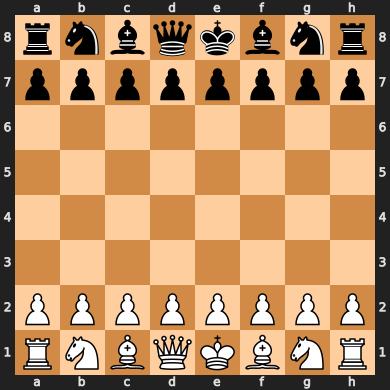

Move 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step




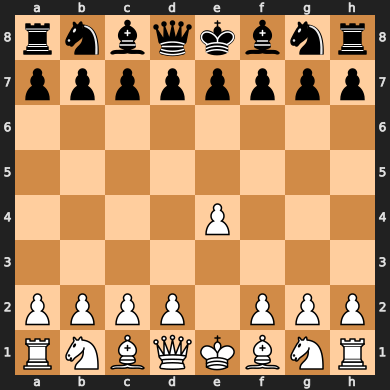

Move 2




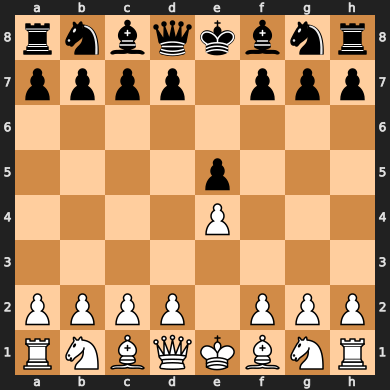

Move 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step




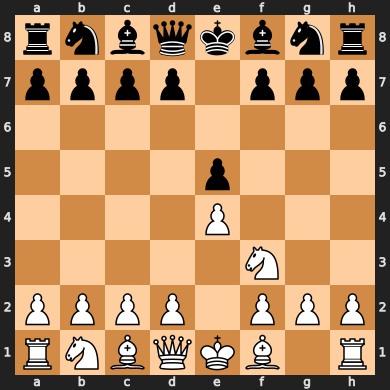

Move 4




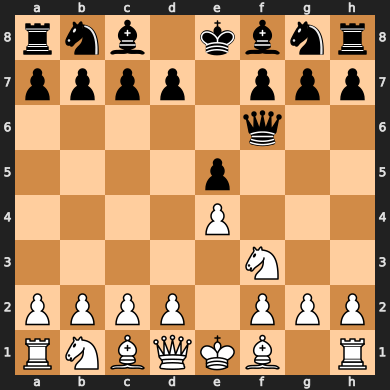

Move 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step




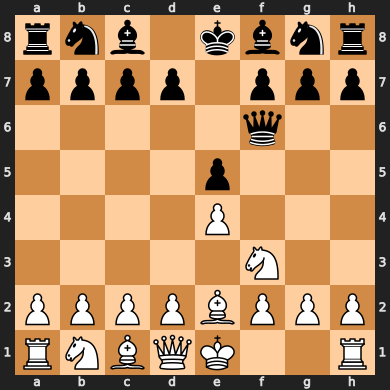

Move 6




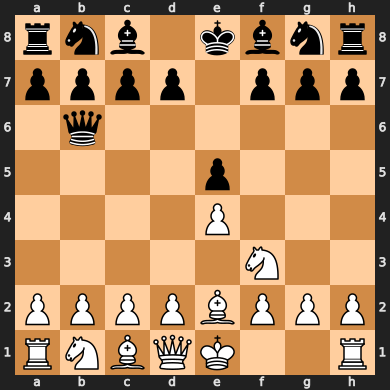

Move 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step




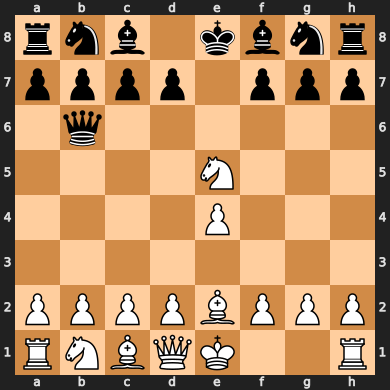

Move 8




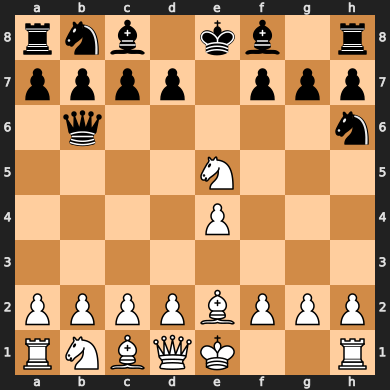

Move 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step




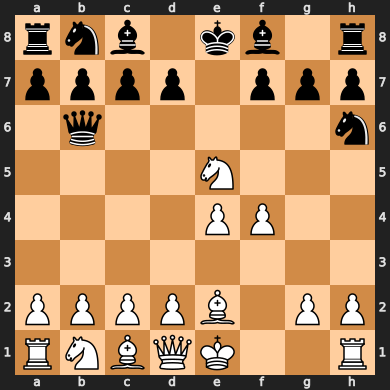

Move 10




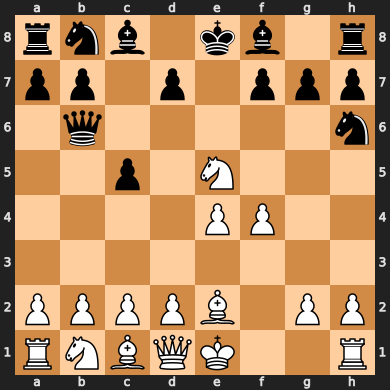

Move 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step




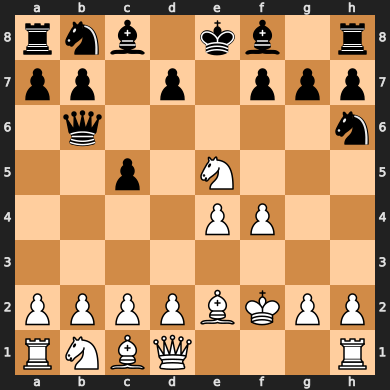

Move 12




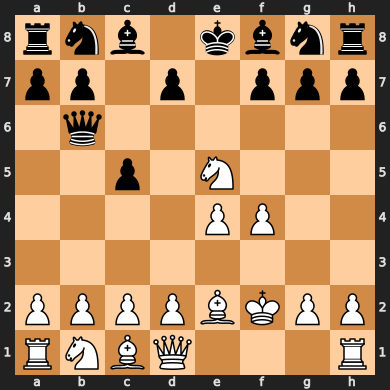

Move 13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step




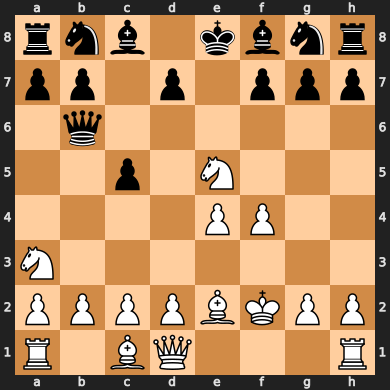

Move 14




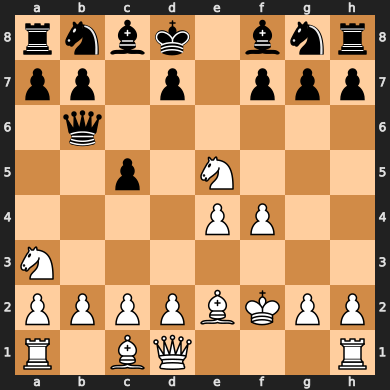

Move 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step




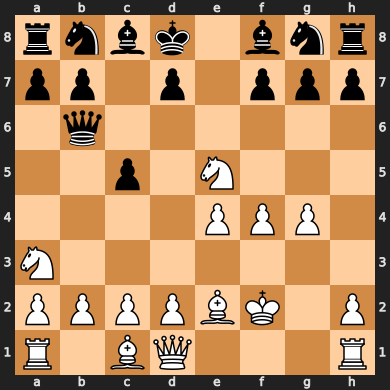

Move 16




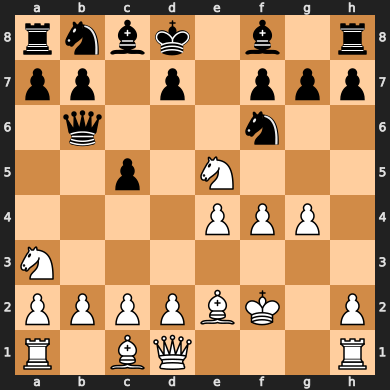

Move 17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step




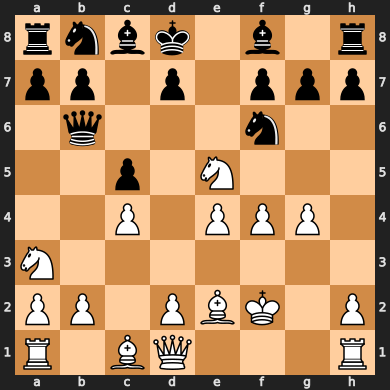

Move 18




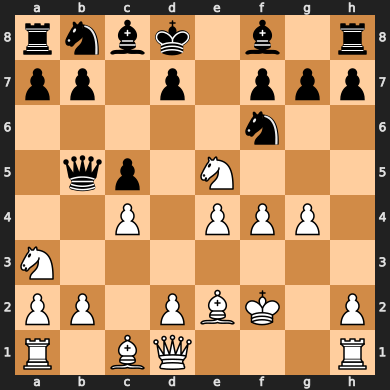

Move 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step




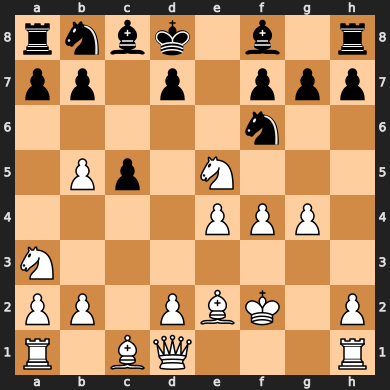

Move 20




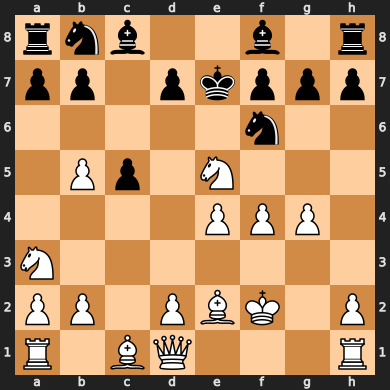

Move 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step




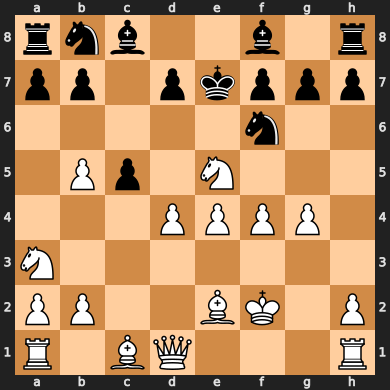

Move 22




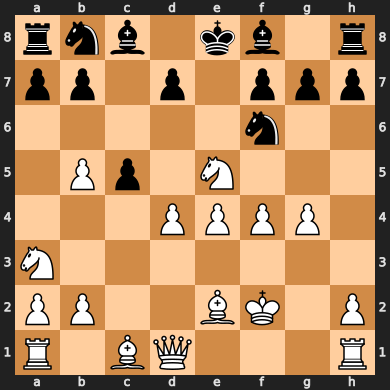

Move 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step




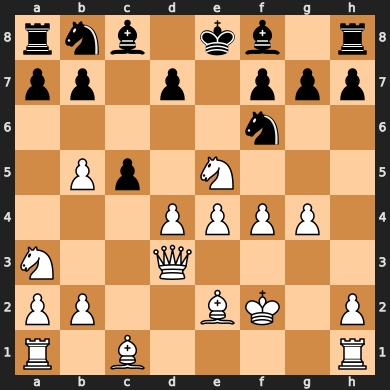

Move 24




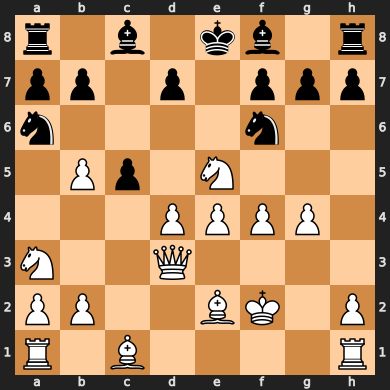

Move 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step




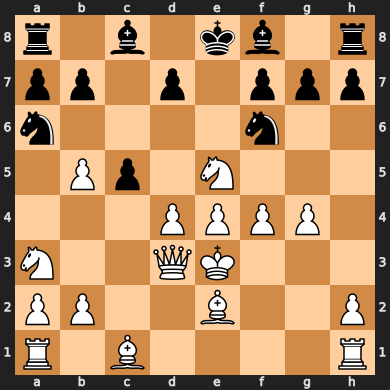

Game over
Result: *


In [1]:
import chess
import chess.svg
from IPython.display import display
import numpy as np
import tensorflow as tf
from cairosvg import svg2png
import io
from PIL import Image

def board_to_array(fen):
    board = chess.Board(fen)
    piece_dict = {'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
                  'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6}
    array = np.zeros((8, 8), dtype=np.int8)
    for i in range(64):
        piece = board.piece_at(i)
        if piece:
            array[i // 8][i % 8] = piece_dict[piece.symbol()]
    return array

def create_model():
    board_input = tf.keras.layers.Input(shape=(8, 8, 1))
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(board_input)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    move_output = tf.keras.layers.Dense(64 * 64, activation='softmax', name='move')(x)
    score_output = tf.keras.layers.Dense(1, name='score')(x)
    
    model = tf.keras.models.Model(inputs=board_input, outputs=[move_output, score_output])
    
    model.compile(optimizer='adam',
                  loss={'move': 'sparse_categorical_crossentropy', 'score': 'mse'},
                  metrics={'move': 'accuracy', 'score': 'mae'})
    
    return model

def predict_move(model, board_fen):
    board_array = board_to_array(board_fen).reshape(1, 8, 8, 1)
    move_probabilities, _ = model.predict(board_array)
    board = chess.Board(board_fen)
    legal_moves = list(board.legal_moves)
    legal_move_indices = [
        move.from_square * 64 + move.to_square
        for move in legal_moves
    ]
    legal_move_probs = move_probabilities[0][legal_move_indices]
    best_move_index = legal_move_indices[np.argmax(legal_move_probs)]
    from_square = chess.SQUARE_NAMES[best_move_index // 64]
    to_square = chess.SQUARE_NAMES[best_move_index % 64]
    return from_square + to_square

def display_board(board):
    svg_content = chess.svg.board(board=board)
    png_image = svg2png(bytestring=svg_content)
    image = Image.open(io.BytesIO(png_image))
    display(image)

# Create the model
model = create_model()

# Load the saved weights
model.load_weights('chess_ai_model.h5')

# Example usage
board = chess.Board()
move_count = 0
max_moves = 25  # Set a maximum number of moves to prevent infinite loops

while not board.is_game_over() and move_count < max_moves:
    display_board(board)
    print(f"Move {move_count + 1}")
    
    if board.turn == chess.WHITE:
        # AI's move
        move = predict_move(model, board.fen())
        try:
            board.push_uci(move)
        except chess.IllegalMoveError:
            print(f"AI attempted illegal move: {move}. Choosing random move.")
            legal_moves = list(board.legal_moves)
            if legal_moves:
                board.push(np.random.choice(legal_moves))
            else:
                print("No legal moves available. Game over.")
                break
    else:
        # Opponent's move (random for this example)
        legal_moves = list(board.legal_moves)
        if legal_moves:
            board.push(np.random.choice(legal_moves))
        else:
            print("No legal moves available. Game over.")
            break
    
    move_count += 1
    print("\n")

display_board(board)
print("Game over")
print("Result:", board.result())

In [ ]:
#800 - 1400 elo